## 思路
* 由于在 Paperspace 上面, 使用 ImageDataGenerator() + flow() 处理 neckline 图片时, 内存不足, memory error 报错
* 因此考虑不将图片全部读入内存, 而是先进行图片预处理, 保存下来, 然后再分批读取的方式, 绕开内存不足的问题
* 在 neckline 里面切出 10 张图片, 作为图片预处理测试

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 切分小样本测试集

In [12]:
# 导入数据, 选取 neckline 内 100 张图片进行小范围验证
df_train = pd.read_csv('../../raw/train/Annotations/label.csv')
df_train.columns = ['image_id', 'class', 'label']

In [13]:
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn
1,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn
2,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn
3,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn
4,Images/collar_design_labels/fc4a679c2bf209de13...,collar_design_labels,ynnnn


In [14]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

In [24]:
cur_class = classes[1]
df_load = df_train[(df_train['class'] == cur_class)][:100].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

neckline_design_labels: 100


,image_id,class,label
0,Images/neckline_design_labels/ce4865335b52b79f...,neckline_design_labels,nnnnnynnnn
1,Images/neckline_design_labels/4f8654c099517d30...,neckline_design_labels,nnnnnnnynn
2,Images/neckline_design_labels/61052e51290d2960...,neckline_design_labels,nnnnnnnynn
3,Images/neckline_design_labels/e948921d89da972c...,neckline_design_labels,ynnnnnnnnn
4,Images/neckline_design_labels/6b81ca0da1970654...,neckline_design_labels,nnnnnnynnn


In [27]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小

X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)

In [28]:
for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
    if len(tmp_label) > n_class:
        print(df_load['image_id'][i])
    X[i] = cv2.resize(cv2.imread('../../raw/train/{0}'.format(df_load['image_id'][i])), (width, width))
    y[i][tmp_label.find('y')] = 1

100%|██████████| 100/100 [00:00<00:00, 126.81it/s]


In [29]:
X.shape, y.shape

((100, 299, 299, 3), (100, 10))

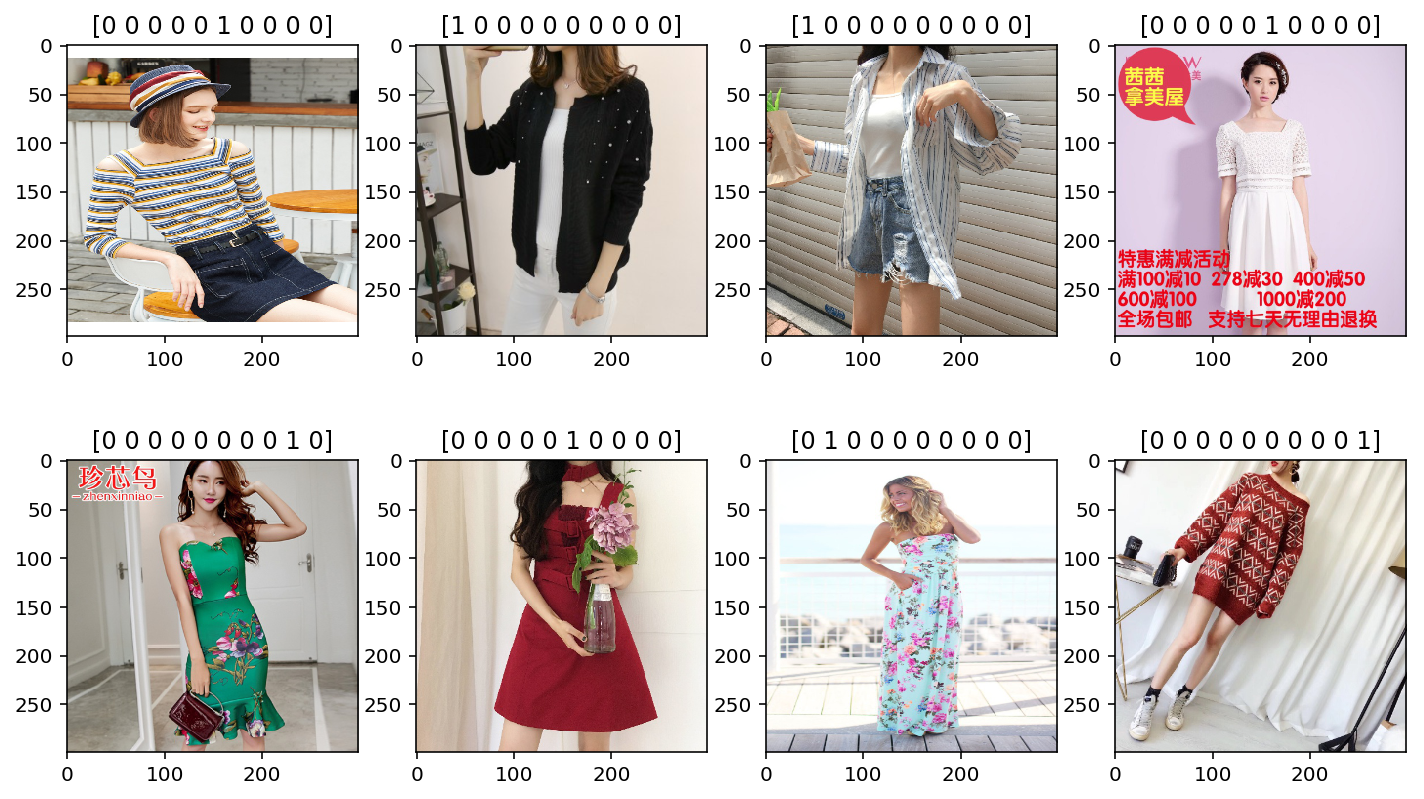

In [31]:
# 随机显示 8 张图片
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(y[random_index])

## 数据预处理

In [3]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [64]:
train_generator = ImageDataGenerator(
        featurewise_center = False, # set input mean to 0 over the dataset
        samplewise_center = False, # set each sample mean to 0
        featurewise_std_normalization = False, # divide inputs by std of the dataset
        samplewise_std_normalization = False, # divide each input by its std
        zca_whitening = False, # apply ZCA whitening
        rotation_range = 10, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # randomly zoom image
        width_shift_range = 0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1, # randomly shift images vertivally (fraction of total heigth)
        horizontal_flip = True, # randomly flip images
        vertical_flip = False,
        shear_range = 0.1,
        fill_mode = 'constant',
        cval = 0)

In [65]:
i = 0
for batch in train_generator.flow_from_directory(
        './train',
        target_size=(299, 299),
        batch_size=32,
        class_mode='input',
        save_to_dir='./preprocessing',
        save_prefix='image'):

    i += 1
    if i > 5: # save 5 images
        break  # otherwise the generator would loop indefinitely

Found 40 images belonging to 4 classes.


# 探索不同预处理方式, 有哪些不同

In [ ]:
# 针对 neckline 领线设计

In [36]:
train_generator = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=0.075, 
        width_shift_range=0.075, 
        height_shift_range=0.075, 
        shear_range=0.075, 
        zoom_range=0.075, 
        channel_shift_range=0.0, 
        fill_mode='nearest', 
        cval=0.0, 
        horizontal_flip=True, 
        vertical_flip=False, 
        rescale=None, 
        preprocessing_function=None, 
        data_format=None, 
#         validation_split=0.0
        )

In [37]:
i = 0
for batch in train_generator.flow_from_directory(
        './train',
        target_size=(299, 299),
        batch_size=16,
        class_mode='input',
        save_to_dir='./preprocessing',
        save_prefix='image'):

    i += 1
    if i > 7: # save 5 images
        break  # otherwise the generator would loop indefinitely

Found 10 images belonging to 1 classes.


### PIL 翻转图片方法

In [43]:
from PIL import Image
import os
import os.path

In [66]:
# resize 到 299×299
rootdir = r'/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels'  # 指明被遍历的文件夹
for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        print('parent is :' + parent)
        print('filename is :' + filename)
        currentPath = os.path.join(parent, filename)
        print('the fulll name of the file is :' + currentPath)
 
        im = Image.open(currentPath)
        out = im.resize((299, 299)) 
        newname=r"/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/preprocessing/"+"0_"+filename
        out.save(newname)

parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a5bfa22ec15c6cb2fa63a9fe201a0f6.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a5bfa22ec15c6cb2fa63a9fe201a0f6.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a6efa71252420d0f585dcc45ad86614.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a6efa71252420d0f585dcc45ad86614.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a9d4f0a36078b271a1228dec8d41067.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a9d4f0a36078b271a1228dec8d41067.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0

In [61]:
# 水平翻转
rootdir = r'/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels'  # 指明被遍历的文件夹
for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        print('parent is :' + parent)
        print('filename is :' + filename)
        currentPath = os.path.join(parent, filename)
        print('the fulll name of the file is :' + currentPath)
 
        im = Image.open(currentPath)
        out = im.transpose(Image.FLIP_LEFT_RIGHT)
        newname=r"/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/preprocessing/"+"1_"+filename
        out.save(newname)

parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a5bfa22ec15c6cb2fa63a9fe201a0f6.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a5bfa22ec15c6cb2fa63a9fe201a0f6.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a6efa71252420d0f585dcc45ad86614.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a6efa71252420d0f585dcc45ad86614.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a9d4f0a36078b271a1228dec8d41067.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a9d4f0a36078b271a1228dec8d41067.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0

In [65]:
# 旋转 20°
rootdir = r'/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels'  # 指明被遍历的文件夹
for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        print('parent is :' + parent)
        print('filename is :' + filename)
        currentPath = os.path.join(parent, filename)
        print('the fulll name of the file is :' + currentPath)
 
        im = Image.open(currentPath)
        out = im.rotate(20)
        newname=r"/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/preprocessing/"+"2_"+filename
        out.save(newname)

parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a5bfa22ec15c6cb2fa63a9fe201a0f6.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a5bfa22ec15c6cb2fa63a9fe201a0f6.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a6efa71252420d0f585dcc45ad86614.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a6efa71252420d0f585dcc45ad86614.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a9d4f0a36078b271a1228dec8d41067.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a9d4f0a36078b271a1228dec8d41067.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0

In [63]:
# 旋转 -20°
rootdir = r'/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels'  # 指明被遍历的文件夹
for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        print('parent is :' + parent)
        print('filename is :' + filename)
        currentPath = os.path.join(parent, filename)
        print('the fulll name of the file is :' + currentPath)
 
        im = Image.open(currentPath)
        out = im.rotate(-20)
        newname=r"/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/preprocessing/"+"3_"+filename
        out.save(newname)

parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a5bfa22ec15c6cb2fa63a9fe201a0f6.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a5bfa22ec15c6cb2fa63a9fe201a0f6.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a6efa71252420d0f585dcc45ad86614.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a6efa71252420d0f585dcc45ad86614.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0a9d4f0a36078b271a1228dec8d41067.jpg
the fulll name of the file is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels/0a9d4f0a36078b271a1228dec8d41067.jpg
parent is :/Users/hugo/Projects/bitbucket/fashionai/ipynb/LiChuan/train/neckline_design_labels
filename is :0

## 实用 opencv 的方法来做预处理